<a href="https://colab.research.google.com/github/fajarwr/Cell_Classification_KAIST/blob/master/Cell_Classification_KAIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#Import Libraries
import os
import sys
#sys.path.append('D:/Documents/Kuliah/DataScience/My Python Libraries')
#import confusion_matrix_pretty_print as cmpp
import pandas as pd
from scipy.stats import zscore
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
#import scikitplot as skplt
#from pandas_ml import ConfusionMatrix
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from pandas import ExcelWriter
from sklearn.model_selection import cross_val_predict
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB

In [2]:
#Mount the drive
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [9]:
#Define Feature Name
feature_name = []
feature_class = ['SA', 'CV', 'SI', 'PD', 'DM']
RI_treshold = [1.340,1.380,0.002]

for feature_idx in range(0,5):
    feature_name += ([feature_class[feature_idx] + x for x in [" {:0.3f}".format(x) for x in np.arange(RI_treshold[0],RI_treshold[1],RI_treshold[2])]])
label_name = ['NUM', 'CHAR']
#Number of feature
print('Number of feature = ', len(feature_name))

Number of feature =  100


In [10]:
cd

/root


In [11]:
cd /content

/content


In [12]:
ls

gdrive/  sample_data/


In [0]:
#Import Feature File
feature_dir = 'gdrive/My Drive/Cell_Classification_KAIST/002_Data'
feature_file_name = "features.xlsx"
label_file_name = "labels.xlsx"
os.chdir(feature_dir)
df_feature = pd.read_excel(feature_file_name,header = None)
df_feature.columns = feature_name
df_label = pd.read_excel(label_file_name,header = None)
df_label[1] = 'CD4'
df_label.loc[df_label[0]==2,(1)] = 'CD8'
df_label.loc[df_label[0]==3,(1)] = 'Memory_CD8'
df_label.loc[df_label[0]==4,(1)] = 'Naive_CD8'
df_label.columns = label_name

In [14]:
print('Print of feature data frame \n', df_feature.head())
print('Print of feature data frame \n', df_label.head())
print(len(df_label.iloc[:,1]=='CD4'))
print('\n Additional information')
print('SA : Specific surface area')
print('CV : Cellular volume')
print('SI : Sphericity')
print('PD : Protein density')
print('DM : Dry mass')
print('1.340, 1.342, ..., 1.378 : Refractive index')
print('NUM : number label')
print('CHAR : Character label')

Print of feature data frame 
      SA 1.340    SA 1.342    SA 1.344  ...   DM 1.374   DM 1.376   DM 1.378
0  336.942628  221.322113  198.905720  ...  25.111034  23.281200  21.027657
1  284.448915  197.500369  175.686598  ...  23.930401  22.835979  21.305340
2  392.447416  274.426477  242.141001  ...  29.064434  27.129330  24.657097
3  391.691157  262.933108  237.742285  ...  28.465515  25.823952  22.306225
4  354.327559  240.273398  210.543228  ...  18.060020  16.559818  14.598180

[5 rows x 100 columns]
Print of feature data frame 
    NUM CHAR
0    1  CD4
1    1  CD4
2    1  CD4
3    1  CD4
4    1  CD4
1231

 Additional information
SA : Specific surface area
CV : Cellular volume
SI : Sphericity
PD : Protein density
DM : Dry mass
1.340, 1.342, ..., 1.378 : Refractive index
NUM : number label
CHAR : Character label


In [0]:
#Pre-feature standardization
df_feature_standardized = df_feature.apply(zscore)

In [0]:
#Define feature & label variavel
X = df_feature_standardized[feature_name].values
y = df_label['NUM'].values

In [0]:
#Merged Data
df = df_feature
df['LABEL'] = df_label['NUM']
df['LYMPHOCYTES CELL'] = df_label['CHAR']

In [0]:
#Train test split
#A : binary classification of CD4 and CD8
#B : binary classification of Memory_CD8 and Naive_CD8
#C : multiclass classification of CD4, Memory_CD8 and Naive_CD8
random_state = 72
X_train_A, X_test_A, y_train_A, y_test_A = train_test_split(X[np.logical_or(y ==1, y ==2),:], y[np.logical_or(y ==1, y ==2)], test_size=0.2, random_state=55, stratify=y[np.logical_or(y ==1, y ==2)])
X_train_B, X_test_B, y_train_B, y_test_B = train_test_split(X[np.logical_or(y ==3, y ==4),:], y[np.logical_or(y ==3, y ==4)], test_size=0.2, random_state=random_state, stratify=y[np.logical_or(y ==3, y ==4)])
X_train_C, X_test_C, y_train_C, y_test_C = train_test_split(X[np.logical_or(np.logical_or(y ==1, y ==3),y ==4),:], y[np.logical_or(np.logical_or(y ==1, y ==3),y ==4)], random_state=random_state, test_size=0.2, stratify=y[np.logical_or(np.logical_or(y ==1, y ==3),y ==4)])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = random_state, stratify=y)

<Figure size 432x288 with 0 Axes>

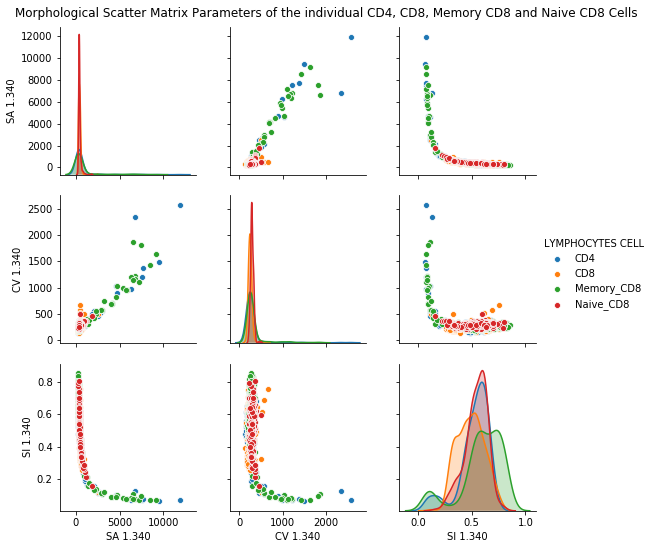

<Figure size 432x288 with 0 Axes>

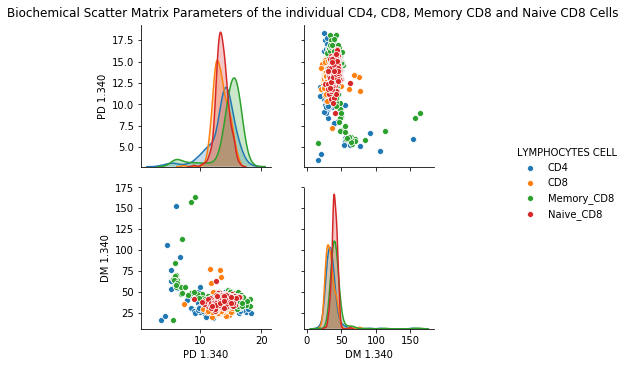

In [0]:
##Explolatory data analysis##

#Plot the xample of selected feature
selected_features = ['SA 1.340', 'CV 1.340', 'SI 1.340']
#Plot Scatter matrix
plt.figure()
sns.pairplot(df, vars=selected_features, hue='LYMPHOCYTES CELL')
plt.suptitle('Morphological Scatter Matrix Parameters of the individual CD4, CD8, Memory CD8 and Naive CD8 Cells',y=1.01)
plt.show()

#Plot the xample of selected feature
selected_features = ['PD 1.340', 'DM 1.340']
#Plot Scatter matrix
plt.figure()
sns.pairplot(df, vars=selected_features, hue='LYMPHOCYTES CELL')
plt.suptitle('Biochemical Scatter Matrix Parameters of the individual CD4, CD8, Memory CD8 and Naive CD8 Cells',y=1.01)
plt.show()

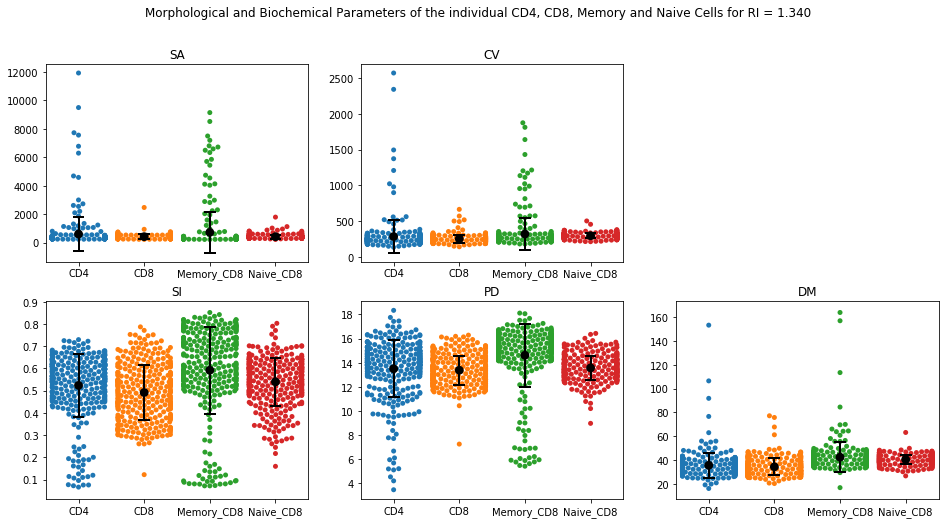

In [0]:
##Explolatory data analysis cont.##
#Plot the xample of selected feature
selected_features = ['SA 1.340', 'CV 1.340', 'SI 1.340', 'PD 1.340', 'DM 1.340']
#Plot scattered data
plt.figure(figsize=(16,8))
for plt_idx in range(0,5):    
    if plt_idx < 2:
        plt.subplot(int('23'+str(plt_idx+1)))
    if plt_idx >= 2:
        plt.subplot(int('23'+str(plt_idx+2)))
    sns.swarmplot(x=df_label['CHAR'].values, y=df_feature[selected_features[plt_idx]].values, zorder=1)
    sns.pointplot(x=df_label['CHAR'].values, y=df_feature[selected_features[plt_idx]].values, ci="sd", estimator=np.mean, join = False, capsize = 0.15, color = 'black', zorder=2, errwidth =2)
    plt.title(feature_class[plt_idx])
plt.suptitle('Morphological and Biochemical Parameters of the individual CD4, CD8, Memory and Naive Cells for RI = 1.340')
plt.show()

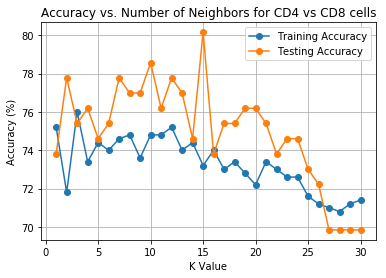

In [0]:
#A case
#Training for Each k (Choosing the best k)
k_range = range(1,31)
k_train_accuracy = []
loo = LeaveOneOut()
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
    k_train_accuracy.append(np.mean(cross_val_score(knn, X_train_A, y_train_A, cv=loo))*100)

#Testing for Each k
k_test_accuracy = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
    knn.fit(X_train_A,y_train_A)
    k_test_accuracy.append(knn.score(X_test_A,y_test_A)*100)

#Ploting accuracy each k value
#The smaller k value, the higher complexity
#The best k value indicated with high accuracy and less complexity
plt.figure
plt.plot(k_range,k_train_accuracy, marker = 'o')
plt.plot(k_range,k_test_accuracy, marker = 'o')
plt.title('Accuracy vs. Number of Neighbors for CD4 vs CD8 cells')
plt.xlabel('K Value')
plt.ylabel('Accuracy (%)')
plt.grid(which = 'both')
plt.legend(['Training Accuracy', 'Testing Accuracy'], loc = 'upper right')
plt.show()

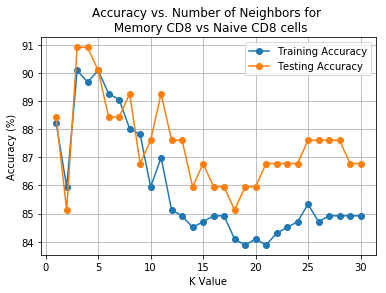

In [0]:
#B case
#Training for Each k (Choosing the best k)
k_range = range(1,31)
k_train_accuracy = []
loo = LeaveOneOut()
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
    k_train_accuracy.append(np.mean(cross_val_score(knn, X_train_B, y_train_B, cv=loo))*100)

#Testing for Each k
k_test_accuracy = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
    knn.fit(X_train_B,y_train_B)
    k_test_accuracy.append(knn.score(X_test_B,y_test_B)*100)

#Ploting accuracy each k value
#The smaller k value, the higher complexity
#The best k value indicated with high accuracy and less complexity
plt.figure
plt.plot(k_range,k_train_accuracy, marker = 'o')
plt.plot(k_range,k_test_accuracy, marker = 'o')
plt.title('Accuracy vs. Number of Neighbors for \n Memory CD8 vs Naive CD8 cells')
plt.xlabel('K Value')
plt.ylabel('Accuracy (%)')
plt.grid(which = 'both')
plt.legend(['Training Accuracy', 'Testing Accuracy'], loc = 'upper right')
plt.show()

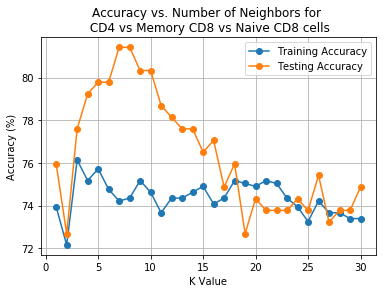

In [0]:
#C case
#Training for Each k (Choosing the best k)
k_range = range(1,31)
k_train_accuracy = []
loo = LeaveOneOut()
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
    k_train_accuracy.append(np.mean(cross_val_score(knn, X_train_C, y_train_C, cv=loo))*100)

#Testing for Each k
k_test_accuracy = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
    knn.fit(X_train_C,y_train_C)
    k_test_accuracy.append(knn.score(X_test_C,y_test_C)*100)

#Ploting accuracy each k value
#The smaller k value, the higher complexity
#The best k value indicated with high accuracy and less complexity
plt.figure
plt.plot(k_range,k_train_accuracy, marker = 'o')
plt.plot(k_range,k_test_accuracy, marker = 'o')
plt.title('Accuracy vs. Number of Neighbors for \n CD4 vs Memory CD8 vs Naive CD8 cells')
plt.xlabel('K Value')
plt.ylabel('Accuracy (%)')
plt.grid(which = 'both')
plt.legend(['Training Accuracy', 'Testing Accuracy'], loc = 'upper right')
plt.show()

In [0]:
#Feature Selection
#Case A
k = 3
knn = KNeighborsClassifier(n_neighbors=k)
loo = LeaveOneOut()
sfs_A = SFS(estimator=knn, k_features=(1,100), scoring='accuracy', cv=loo)
sfs_A.fit(X_train_A, y_train_A,custom_feature_names=feature_name)
print('best combination (ACC: %.3f): %s\n' % (sfs_A.k_score_, sfs_A.k_feature_names_))
df_sfs_A = pd.DataFrame.from_dict(sfs_A.get_metric_dict()).T

best combination (ACC: 0.836): ('SA 1.340', 'SA 1.342', 'SA 1.344', 'SA 1.346', 'SI 1.342', 'SI 1.344', 'SI 1.370', 'SI 1.372', 'SI 1.374', 'PD 1.346', 'PD 1.354', 'PD 1.360', 'PD 1.362', 'PD 1.364', 'PD 1.378')



In [0]:
#Case B
k = 3
knn = KNeighborsClassifier(n_neighbors=k)
loo = LeaveOneOut()
sfs_B = SFS(estimator=knn, k_features=(1,100), scoring='accuracy', cv=loo)
sfs_B.fit(X_train_B, y_train_B,custom_feature_names=feature_name)
print('best combination (ACC: %.3f): %s\n' % (sfs_B.k_score_, sfs_B.k_feature_names_))
df_sfs_B = pd.DataFrame.from_dict(sfs_B.get_metric_dict()).T 

best combination (ACC: 0.959): ('SA 1.340', 'SA 1.342', 'SA 1.344', 'SA 1.346', 'SA 1.348', 'CV 1.342', 'SI 1.340', 'SI 1.342', 'SI 1.344', 'SI 1.348', 'SI 1.362', 'SI 1.364', 'SI 1.374', 'SI 1.376', 'PD 1.340', 'PD 1.364', 'PD 1.372', 'PD 1.374', 'PD 1.376')



In [0]:
#Case C
k = 3
knn = KNeighborsClassifier(n_neighbors=k)
loo = LeaveOneOut()
sfs_C = SFS(estimator=knn, k_features=(1,100), scoring='accuracy', cv=loo)
sfs_C.fit(X_train_C, y_train_C,custom_feature_names=feature_name)
print('best combination (ACC: %.3f): %s\n' % (sfs_C.k_score_, sfs_C.k_feature_names_))
df_sfs_C = pd.DataFrame.from_dict(sfs_C.get_metric_dict()).T

best combination (ACC: 0.850): ('CV 1.376', 'SI 1.340', 'SI 1.374', 'PD 1.340', 'PD 1.376', 'PD 1.378', 'DM 1.368')



In [0]:
pwd

'/content/gdrive/My Drive/Cell_Classification_KAIST/002_Data'

In [0]:
#Save and load

df_sfs_A.to_excel('df_sfs_A.xlsx')
df_sfs_B.to_excel('df_sfs_B.xlsx')
df_sfs_C.to_excel('df_sfs_C.xlsx')

df_sfs_A = pd.read_excel('df_sfs_A.xlsx')
df_sfs_B = pd.read_excel('df_sfs_B.xlsx')
df_sfs_C = pd.read_excel('df_sfs_C.xlsx')

<function matplotlib.pyplot.show>

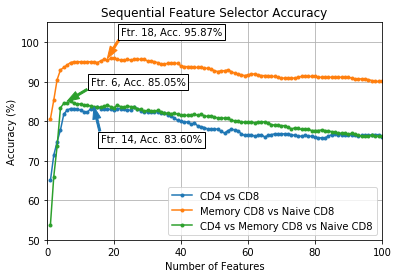

In [0]:
#Show feature selection result
plt.figure
p = plt.plot(np.arange(1,101),df_sfs_A['avg_score'].values*100, np.arange(1,101),df_sfs_B['avg_score'].values*100, np.arange(1,101),df_sfs_C['avg_score'].values*100, marker = 'o', markersize=3)
plt.axis([0, 100, 50, 105])
plt.title('Sequential Feature Selector Accuracy')
plt.xlabel('Number of Features')
plt.ylabel('Accuracy (%)')
plt.grid(which = 'both')
plt.legend(['CD4 vs CD8', 'Memory CD8 vs Naive CD8', 'CD4 vs Memory CD8 vs Naive CD8'], loc = 'lower right')
xy = (df_sfs_A.index[df_sfs_A['avg_score']==np.max(df_sfs_A['avg_score'])][0], np.max(df_sfs_A['avg_score'])*100)
xytext = (df_sfs_A.index[df_sfs_A['avg_score']==np.max(df_sfs_A['avg_score'])][0]+2, np.max(df_sfs_A['avg_score'])*100-9)
text = 'Ftr. %d, Acc. %.2f%%' % (df_sfs_A.index[df_sfs_A['avg_score']==np.max(df_sfs_A['avg_score'])][0], np.max(df_sfs_A['avg_score'])*100)
plt.annotate(text, xy=xy, xytext=xytext, arrowprops={'color':p[0].get_color(), 'width':2, 'headwidth':8}, bbox={'boxstyle':'square', 'fc':'w'})
xy = (df_sfs_B.index[df_sfs_B['avg_score']==np.max(df_sfs_B['avg_score'])][0], np.max(df_sfs_B['avg_score'])*100)
xytext = (df_sfs_B.index[df_sfs_B['avg_score']==np.max(df_sfs_B['avg_score'])][0]+4, np.max(df_sfs_B['avg_score'])*100+6)
text = 'Ftr. %d, Acc. %.2f%%' % (df_sfs_B.index[df_sfs_B['avg_score']==np.max(df_sfs_B['avg_score'])][0], np.max(df_sfs_B['avg_score'])*100)
plt.annotate(text, xy=xy, xytext=xytext, arrowprops={'color':p[1].get_color(), 'width':2, 'headwidth':8}, bbox={'boxstyle':'square', 'fc':'w'})
xy = (df_sfs_C.index[df_sfs_C['avg_score']==np.max(df_sfs_C['avg_score'])][0], np.max(df_sfs_C['avg_score'])*100)
xytext = (df_sfs_C.index[df_sfs_C['avg_score']==np.max(df_sfs_C['avg_score'])][0]+7, np.max(df_sfs_C['avg_score'])*100+4)
text = 'Ftr. %d, Acc. %.2f%%' % (df_sfs_C.index[df_sfs_C['avg_score']==np.max(df_sfs_C['avg_score'])][0], np.max(df_sfs_C['avg_score'])*100)
plt.annotate(text, xy=xy, xytext=xytext, arrowprops={'color':p[2].get_color(), 'width':2, 'headwidth':8}, bbox={'boxstyle':'square', 'fc':'w'})
plt.show

In [6]:
#Define feature & label variavel from feature selection
selected_feature_A = ['SA 1.340', 'SA 1.342', 'SA 1.344', 'SA 1.346', 'SI 1.342', 'SI 1.344', 'SI 1.370', 'SI 1.372', 'SI 1.374', 'PD 1.346', 'PD 1.354', 'PD 1.360', 'PD 1.362', 'PD 1.364', 'PD 1.378']
selected_feature_B = ['SA 1.340', 'SA 1.342', 'SA 1.344', 'SA 1.346', 'SA 1.348', 'CV 1.342', 'SI 1.340', 'SI 1.342', 'SI 1.344', 'SI 1.348', 'SI 1.362', 'SI 1.364', 'SI 1.374', 'SI 1.376', 'PD 1.340', 'PD 1.364', 'PD 1.372', 'PD 1.374', 'PD 1.376']
selected_feature_C = ['CV 1.376', 'SI 1.340', 'SI 1.374', 'PD 1.340', 'PD 1.376', 'PD 1.378', 'DM 1.368']
#Select the feature
X_A = df_feature_standardized[selected_feature_A].values
X_B = df_feature_standardized[selected_feature_B].values
X_C = df_feature_standardized[selected_feature_C].values
y = df_label['NUM'].values

NameError: ignored

In [7]:
#Data Merged
df = df_feature
df['LABEL'] = df_label['NUM']
df['LYMPHOCYTES CELL'] = df_label['CHAR']

NameError: ignored

In [8]:
#Train test split
#A : binary classification of CD4 and CD8
#B : binary classification of Memory_CD8 and Naive_CD8
#C : multiclass classification of CD4, Memory_CD8 and Naive_CD8
random_state = 72
X_train_A, X_test_A, y_train_A, y_test_A = train_test_split(X_A[np.logical_or(y ==1, y ==2),:], y[np.logical_or(y ==1, y ==2)], test_size=0.2, random_state=55, stratify=y[np.logical_or(y ==1, y ==2)])
X_train_B, X_test_B, y_train_B, y_test_B = train_test_split(X_B[np.logical_or(y ==3, y ==4),:], y[np.logical_or(y ==3, y ==4)], test_size=0.2, random_state=random_state, stratify=y[np.logical_or(y ==3, y ==4)])
X_train_C, X_test_C, y_train_C, y_test_C = train_test_split(X_C[np.logical_or(np.logical_or(y ==1, y ==3),y ==4),:], y[np.logical_or(np.logical_or(y ==1, y ==3),y ==4)], random_state=random_state, test_size=0.2, stratify=y[np.logical_or(np.logical_or(y ==1, y ==3),y ==4)])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = random_state, stratify=y)

NameError: ignored

Case A, Confusion Matrix Train :
[[205  40]
 [ 42 213]]
Case A, Confusion Matrix Test :
[[51 11]
 [13 51]]
Train acc. 83.600000
Test acc. 80.952381


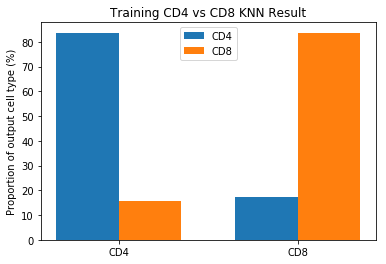

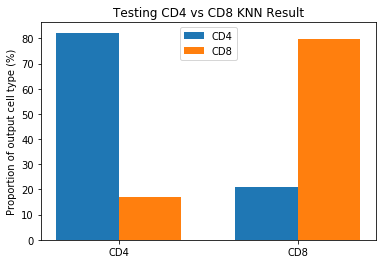

In [51]:
#Show the result
#Dont forget to choose selected feature
#A Case
loo = LeaveOneOut()
k = 3
knn = KNeighborsClassifier(n_neighbors=k)
y_pred = cross_val_predict(knn, X_train_A, y_train_A, cv=loo)
cm_train = confusion_matrix(y_train_A,  y_pred)
print('Case A, Confusion Matrix Train :')
print(cm_train)
knn.fit(X_train_A,y_train_A)
cm_test = confusion_matrix(y_test_A,  knn.predict(X_test_A))
print('Case A, Confusion Matrix Test :')
print(cm_test)
print('Train acc. %f' %(np.mean(cross_val_score(knn, X_train_A, y_train_A, cv=loo))*100))
print('Test acc. %f' %(knn.score(X_test_A,y_test_A)*100))

N = 2
ind = np.arange(N)
width = 0.35
CD4_out = cm_train[:,0]/np.sum(cm_train[0,:])*100
CD8_out = cm_train[:,1]/np.sum(cm_train[1,:])*100
plt.bar(ind,CD4_out, width, label='CD4')
plt.bar(ind+width,CD8_out, width, label='CD8')
plt.ylabel('Proportion of output cell type (%)')
plt.title('Training CD4 vs CD8 KNN Result')
plt.xticks(ind + width / 2, ('CD4', 'CD8'))
plt.legend(loc='best')
plt.show()

N = 2
ind = np.arange(N)
width = 0.35
CD4_out = cm_test[:,0]/np.sum(cm_test[0,:])*100
CD8_out = cm_test[:,1]/np.sum(cm_test[1,:])*100
plt.bar(ind,CD4_out, width, label='CD4')
plt.bar(ind+width,CD8_out, width, label='CD8')
plt.ylabel('Proportion of output cell type (%)')
plt.title('Testing CD4 vs CD8 KNN Result')
plt.xticks(ind + width / 2, ('CD4', 'CD8'))
plt.legend(loc='best')
plt.show()

Case B, Confusion Matrix Train :
[[225  12]
 [  8 239]]
Case B, Confusion Matrix Test :
[[58  1]
 [ 5 57]]
Train acc. 95.867769
Test acc. 95.041322


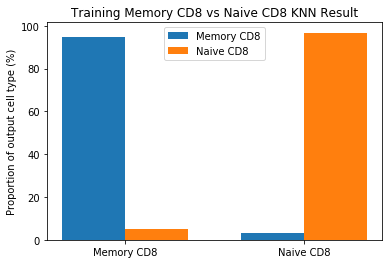

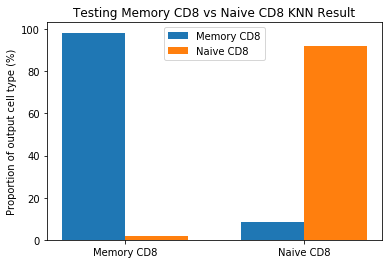

In [69]:
#Dont forget to choose selected feature
#B Case
loo = LeaveOneOut()
k = 3
knn = KNeighborsClassifier(n_neighbors=k)
y_pred = cross_val_predict(knn, X_train_B, y_train_B, cv=loo)
cm_train = confusion_matrix(y_train_B,  y_pred)
print('Case B, Confusion Matrix Train :')
print(cm_train)
knn.fit(X_train_B,y_train_B)
cm_test = confusion_matrix(y_test_B,  knn.predict(X_test_B))
print('Case B, Confusion Matrix Test :')
print(cm_test)
print('Train acc. %f' %(np.mean(cross_val_score(knn, X_train_B, y_train_B, cv=loo))*100))
print('Test acc. %f' %(knn.score(X_test_B,y_test_B)*100))

N = 2
ind = np.arange(N)
width = 0.35
MCD8_out = cm_train[:,0]/np.sum(cm_train[0,:])*100
NCD8_out = cm_train[:,1]/np.sum(cm_train[1,:])*100
plt.bar(ind,MCD8_out, width, label='Memory CD8')
plt.bar(ind+width,NCD8_out, width, label='Naive CD8')
plt.ylabel('Proportion of output cell type (%)')
plt.title('Training Memory CD8 vs Naive CD8 KNN Result')
plt.xticks(ind + width / 2, ('Memory CD8', 'Naive CD8'))
plt.legend(loc='best')
plt.show()

N = 2
ind = np.arange(N)
width = 0.35
MCD8_out = cm_test[:,0]/np.sum(cm_test[0,:])*100
NCD8_out = cm_test[:,1]/np.sum(cm_test[1,:])*100
plt.bar(ind,MCD8_out, width, label='Memory CD8')
plt.bar(ind+width,NCD8_out, width, label='Naive CD8')
plt.ylabel('Proportion of output cell type (%)')
plt.title('Testing Memory CD8 vs Naive CD8 KNN Result')
plt.xticks(ind + width / 2, ('Memory CD8', 'Naive CD8'))
plt.legend(loc='best')
plt.show()

Case C, Confusion Matrix Train :
[[198  33  14]
 [ 25 197  15]
 [ 13   9 225]]
Case C, Confusion Matrix Test :
[[51  9  2]
 [ 9 45  5]
 [ 5  1 56]]
Train acc. 85.048011
Test acc. 83.060109


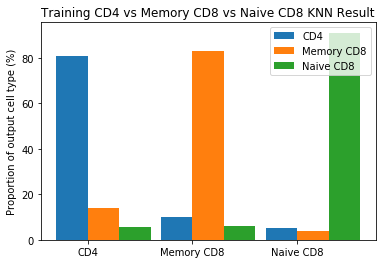

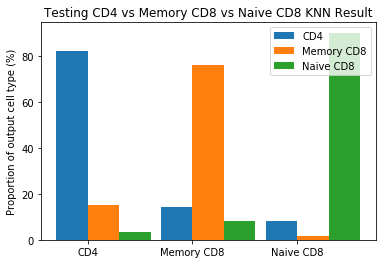

In [61]:
#Dont forget to choose selected feature
#C Case
loo = LeaveOneOut()
k = 3
knn = KNeighborsClassifier(n_neighbors=k)
y_pred = cross_val_predict(knn, X_train_C, y_train_C, cv=loo)
cm_train = confusion_matrix(y_train_C,  y_pred)
print('Case C, Confusion Matrix Train :')
print(cm_train)
knn.fit(X_train_C,y_train_C)
cm_test = confusion_matrix(y_test_C,  knn.predict(X_test_C))
print('Case C, Confusion Matrix Test :')
print(cm_test)
print('Train acc. %f' %(np.mean(cross_val_score(knn, X_train_C, y_train_C, cv=loo))*100))
print('Test acc. %f' %(knn.score(X_test_C,y_test_C)*100))


N = 3
ind = np.arange(N)
width = 0.3
CD4_out = cm_train[:,0]/np.sum(cm_train[0,:])*100
MCD8_out = cm_train[:,1]/np.sum(cm_train[1,:])*100
NCD8_out = cm_train[:,2]/np.sum(cm_train[2,:])*100
plt.bar(ind,CD4_out, width, label='CD4')
plt.bar(ind+width,MCD8_out, width, label='Memory CD8')
plt.bar(ind+2*width,NCD8_out, width, label='Naive CD8')
plt.ylabel('Proportion of output cell type (%)')
plt.title('Training CD4 vs Memory CD8 vs Naive CD8 KNN Result')
plt.xticks(ind + width / 2, ('CD4', 'Memory CD8', 'Naive CD8'))
plt.legend(loc='best')
plt.show()

N = 3
ind = np.arange(N)
width = 0.3
CD4_out = cm_test[:,0]/np.sum(cm_test[0,:])*100
MCD8_out = cm_test[:,1]/np.sum(cm_test[1,:])*100
NCD8_out = cm_test[:,2]/np.sum(cm_test[2,:])*100
plt.bar(ind,CD4_out, width, label='CD4')
plt.bar(ind+width,MCD8_out, width, label='Memory CD8')
plt.bar(ind+2*width,NCD8_out, width, label='Naive CD8')
plt.ylabel('Proportion of output cell type (%)')
plt.title('Testing CD4 vs Memory CD8 vs Naive CD8 KNN Result')
plt.xticks(ind + width / 2, ('CD4', 'Memory CD8', 'Naive CD8'))
plt.legend(loc='best')
plt.show()

In [5]:
cd 'gdrive/My Drive/Cell_Classification_KAIST/002_Data'

/content/gdrive/My Drive/Cell_Classification_KAIST/002_Data


In [0]:
#Tuning SVM parameter
loo = LeaveOneOut()
C_range = 10. ** np.arange(6, 7)
gamma_range = 10. ** np.arange(-5, 4)
scores_A = np.zeros((len(C_range), len(gamma_range)))
row_idx = 0
for C_idx in C_range :
    col_idx = 0
    for gamma_idx inxz gamma_range:
        svm = SVC(C=C_idx, gamma=gamma_idx)
        scores_A[row_idx][col_idx] = np.mean(cross_val_score(svm, X_train_A, y_train_A, cv=loo))*100
        col_idx += 1
    row_idx += 1
loo = LeaveOneOut()
C_range = 10. ** np.arange(6, 7)
gamma_range = 10. ** np.arange(-5, 4)
scores_B = np.zeros((len(C_range), len(gamma_range)))
row_idx = 0
for C_idx in C_range :
    col_idx = 0
    for gamma_idx inxz gamma_range:
        svm = SVC(C=C_idx, gamma=gamma_idx)
        scores_B[row_idx][col_idx] = np.mean(cross_val_score(svm, X_train_A, y_train_A, cv=loo))*100
        col_idx += 1
    row_idx += 1
loo = LeaveOneOut()
C_range = 10. ** np.arange(6, 7)
gamma_range = 10. ** np.arange(-5, 4)
scores_C = np.zeros((len(C_range), len(gamma_range)))
row_idx = 0
for C_idx in C_range :
    col_idx = 0
    for gamma_idx inxz gamma_range:
        svm = SVC(C=C_idx, gamma=gamma_idx)
        scores_C[row_idx][col_idx] = np.mean(cross_val_score(svm, X_train_A, y_train_A, cv=loo))*100
        col_idx += 1
    row_idx += 1

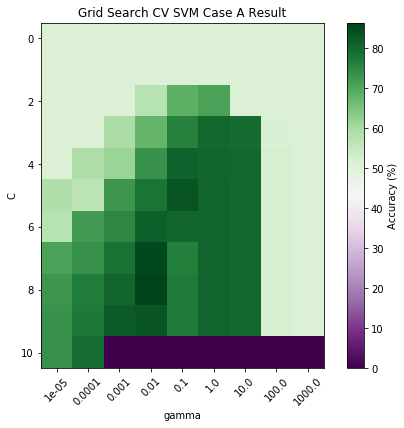

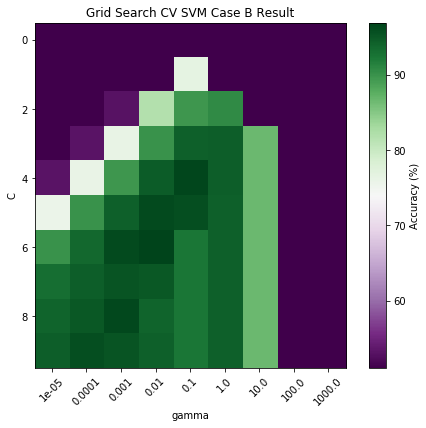

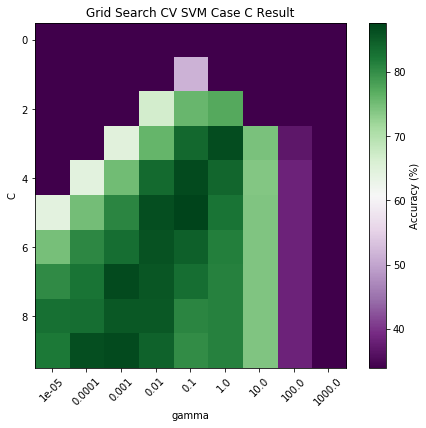

In [25]:
scores_A = np.load('scores_A.npy')
scores_B = np.load('scores_B.npy')
scores_C = np.load('scores_C.npy')
# Grid Search CV SVM Case A
C_range = 10. ** np.arange(6, 7)
gamma_range = 10. ** np.arange(-5, 4)
plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=0.15, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores_A, interpolation='nearest', cmap='PRGn')
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar(label='Accuracy (%)')
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.title('Grid Search CV SVM Case A Result')
plt.show()
# Grid Search CV SVM Case B
C_range = 10. ** np.arange(6, 7)
gamma_range = 10. ** np.arange(-5, 4)
plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=0.15, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores_B, interpolation='nearest', cmap='PRGn')
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar(label='Accuracy (%)')
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.title('Grid Search CV SVM Case B Result')
plt.show()
# Grid Search CV SVM Case C
C_range = 10. ** np.arange(6, 7)
gamma_range = 10. ** np.arange(-5, 4)
plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=0.15, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores_C, interpolation='nearest', cmap='PRGn')
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar(label='Accuracy (%)')
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.title('Grid Search CV SVM Case C Result')
plt.show()

Case A, Confusion Matrix Train :
[[212  33]
 [ 35 220]]
Case A, Confusion Matrix Test :
[[49 13]
 [ 7 57]]
Test acc. 84.126984


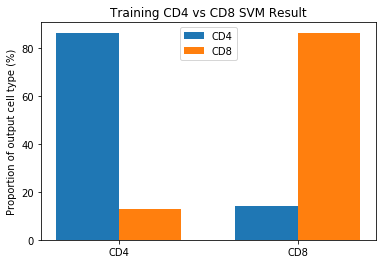

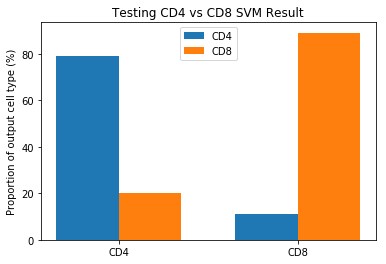

In [65]:
#Show the SVM result
#A Case
loo = LeaveOneOut()
svm = SVC(C=100000, gamma=0.01)
y_pred = cross_val_predict(svm, X_train_A, y_train_A, cv=loo)
cm_train = confusion_matrix(y_train_A,  y_pred)
print('Case A, Confusion Matrix Train :')
print(cm_train)
svm.fit(X_train_A,y_train_A)
cm_test = confusion_matrix(y_test_A,  svm.predict(X_test_A))
print('Case A, Confusion Matrix Test :')
print(cm_test)
#print('Train acc. %f' %(np.mean(cross_val_score(svm, X_train_A, y_train_A, cv=loo))*100))
print('Test acc. %f' %(svm.score(X_test_A,y_test_A)*100))


N = 2
ind = np.arange(N)
width = 0.35
CD4_out = cm_train[:,0]/np.sum(cm_train[0,:])*100
CD8_out = cm_train[:,1]/np.sum(cm_train[1,:])*100
plt.bar(ind,CD4_out, width, label='CD4')
plt.bar(ind+width,CD8_out, width, label='CD8')
plt.ylabel('Proportion of output cell type (%)')
plt.title('Training CD4 vs CD8 SVM Result')
plt.xticks(ind + width / 2, ('CD4', 'CD8'))
plt.legend(loc='best')
plt.show()

N = 2
ind = np.arange(N)
width = 0.35
CD4_out = cm_test[:,0]/np.sum(cm_test[0,:])*100
CD8_out = cm_test[:,1]/np.sum(cm_test[1,:])*100
plt.bar(ind,CD4_out, width, label='CD4')
plt.bar(ind+width,CD8_out, width, label='CD8')
plt.ylabel('Proportion of output cell type (%)')
plt.title('Testing CD4 vs CD8 SVM Result')
plt.xticks(ind + width / 2, ('CD4', 'CD8'))
plt.legend(loc='best')
plt.show()

Case B, Confusion Matrix Train :
[[230   7]
 [  9 238]]
Case B, Confusion Matrix Test :
[[59  0]
 [ 6 56]]
Test acc. 95.041322


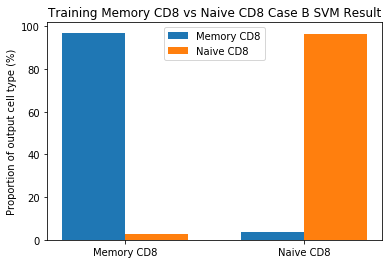

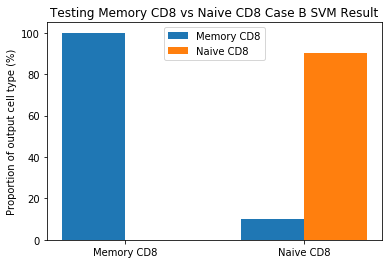

In [71]:
#B Case
loo = LeaveOneOut()
svm = SVC(C=10, gamma=0.1)
y_pred = cross_val_predict(svm, X_train_B, y_train_B, cv=loo)
cm_train = confusion_matrix(y_train_B,  y_pred)
print('Case B, Confusion Matrix Train :')
print(cm_train)
svm.fit(X_train_B,y_train_B)
cm_test = confusion_matrix(y_test_B,  svm.predict(X_test_B))
print('Case B, Confusion Matrix Test :')
print(cm_test)
#print('Train acc. %f' %(np.mean(cross_val_score(svm, X_train_B, y_train_B, cv=loo))*100))
print('Test acc. %f' %(svm.score(X_test_B,y_test_B)*100))

N = 2
ind = np.arange(N)
width = 0.35
MCD8_out = cm_train[:,0]/np.sum(cm_train[0,:])*100
NCD8_out = cm_train[:,1]/np.sum(cm_train[1,:])*100
plt.bar(ind,MCD8_out, width, label='Memory CD8')
plt.bar(ind+width,NCD8_out, width, label='Naive CD8')
plt.ylabel('Proportion of output cell type (%)')
plt.title('Training Memory CD8 vs Naive CD8 Case B SVM Result')
plt.xticks(ind + width / 2, ('Memory CD8', 'Naive CD8'))
plt.legend(loc='best')
plt.show()

N = 2
ind = np.arange(N)
width = 0.35
MCD8_out = cm_test[:,0]/np.sum(cm_test[0,:])*100
NCD8_out = cm_test[:,1]/np.sum(cm_test[1,:])*100
plt.bar(ind,MCD8_out, width, label='Memory CD8')
plt.bar(ind+width,NCD8_out, width, label='Naive CD8')
plt.ylabel('Proportion of output cell type (%)')
plt.title('Testing Memory CD8 vs Naive CD8 Case B SVM Result')
plt.xticks(ind + width / 2, ('Memory CD8', 'Naive CD8'))
plt.legend(loc='best')
plt.show()

Case C, Confusion Matrix Train :
[[204  30  11]
 [ 23 203  11]
 [  7   8 232]]
Case C, Confusion Matrix Test :
[[51  7  4]
 [ 5 51  3]
 [ 2  1 59]]
Test acc. 87.978142


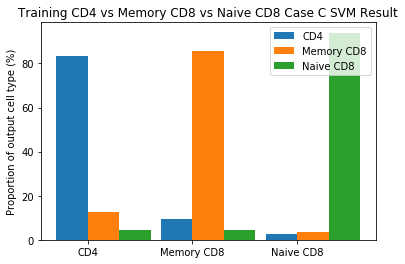

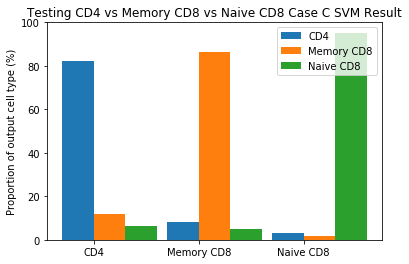

In [76]:
#Dont forget to choose selected feature
#C Case
loo = LeaveOneOut()
svm = SVC(C=100, gamma=0.1)
y_pred = cross_val_predict(svm, X_train_C, y_train_C, cv=loo)
cm_train = confusion_matrix(y_train_C,  y_pred)
print('Case C, Confusion Matrix Train :')
print(cm_train)
svm.fit(X_train_C,y_train_C)
cm_test = confusion_matrix(y_test_C,  svm.predict(X_test_C))
print('Case C, Confusion Matrix Test :')
print(cm_test)
#print('Train acc. %f' %(np.mean(cross_val_score(svm, X_train_C, y_train_C, cv=loo))*100))
print('Test acc. %f' %(svm.score(X_test_C,y_test_C)*100))


N = 3
ind = np.arange(N)
width = 0.3
CD4_out = cm_train[:,0]/np.sum(cm_train[0,:])*100
MCD8_out = cm_train[:,1]/np.sum(cm_train[1,:])*100
NCD8_out = cm_train[:,2]/np.sum(cm_train[2,:])*100
plt.bar(ind,CD4_out, width, label='CD4')
plt.bar(ind+width,MCD8_out, width, label='Memory CD8')
plt.bar(ind+2*width,NCD8_out, width, label='Naive CD8')
plt.ylabel('Proportion of output cell type (%)')
plt.title('Training CD4 vs Memory CD8 vs Naive CD8 Case C SVM Result')
plt.xticks(ind + width / 2, ('CD4', 'Memory CD8', 'Naive CD8'))
plt.legend(loc='best')
plt.show()

N = 3
ind = np.arange(N)
width = 0.3
CD4_out = cm_test[:,0]/np.sum(cm_test[0,:])*100
MCD8_out = cm_test[:,1]/np.sum(cm_test[1,:])*100
NCD8_out = cm_test[:,2]/np.sum(cm_test[2,:])*100
plt.bar(ind,CD4_out, width, label='CD4')
plt.bar(ind+width,MCD8_out, width, label='Memory CD8')
plt.bar(ind+2*width,NCD8_out, width, label='Naive CD8')
plt.ylabel('Proportion of output cell type (%)')
plt.title('Testing CD4 vs Memory CD8 vs Naive CD8 Case C SVM Result')
plt.xticks(ind + width / 2, ('CD4', 'Memory CD8', 'Naive CD8'))
plt.legend(loc='best')
plt.show()

In [0]:
#Random forrest tunning parameter
#n_estimators : number of tree
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
}

loo = LeaveOneOut()
rfc = RandomForestClassifier(random_state=random_state)
grid_search = GridSearchCV(estimator = rfc, param_grid = param_grid, cv = loo, scoring = 'accuracy', n_jobs=-1)
grid_search.fit(X_train_A, y_train_A)
df_rfc_B = pd.DataFrame.from_dict(grid_search.cv_results_)
grid_search.fit(X_train_B, y_train_B)
df_rfc_B = pd.DataFrame.from_dict(grid_search.cv_results_)
grid_search.fit(X_train_C, y_train_C)
df_rfc_C = pd.DataFrame.from_dict(grid_search.cv_results_)


writer = pd.ExcelWriter('df_rfc_A.xlsx')
df_rfc_A.to_excel(writer,'Sheet1')
writer.save()
writer = pd.ExcelWriter('df_rfc_B.xlsx')
df_rfc_B.to_excel(writer,'Sheet1')
writer.save()
writer = pd.ExcelWriter('df_rfc_C.xlsx')
df_rfc_C.to_excel(writer,'Sheet1')
writer.save()

In [0]:
df_rfc_A = pd.read_excel('df_rfc_A.xlsx')
df_rfc_B = pd.read_excel('df_rfc_B.xlsx')
df_rfc_C = pd.read_excel('df_rfc_C.xlsx')
x = []
y_A = []
y_B = []
y_C = []
for idx in range(0,11):
    #n of tree
    if idx < 5:
        x.append(df_rfc_A.loc[idx]['param_n_estimators'])
        y_A.append(df_rfc_A.loc[idx]['mean_test_score']*100)
        y_B.append(df_rfc_B.loc[idx]['mean_test_score']*100)
        y_C.append(df_rfc_C.loc[idx]['mean_test_score']*100)
    #if 4 <= idx < 10:
#        x.append(df_rfc_A_.loc[idx-4]['param_n_estimators'])
#        y_A.append(df_rfc_A_.loc[idx-4]['mean_test_score']*100)
#        y_B.append(df_rfc_B_.loc[idx-4]['mean_test_score']*100)
#        y_C.append(df_rfc_C_.loc[idx-4]['mean_test_score']*100)
#    if idx == 10:
#        x.append(df_rfc_A.loc[idx-6]['param_n_estimators'])
#        y_A.append(df_rfc_A.loc[idx-6]['mean_test_score']*100)
#        y_B.append(df_rfc_B.loc[idx-6]['mean_test_score']*100)
#        y_C.append(df_rfc_C.loc[idx-6]['mean_test_score']*100)

In [97]:
x

[50, 100, 200, 300, 1000]

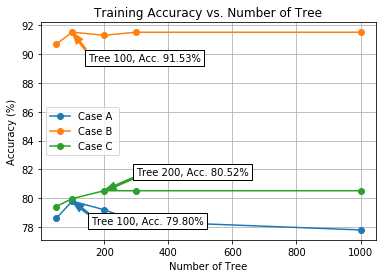

In [102]:
#Plot random forrest tunning result
plt.figure
p = plt.plot(x,y_A, x, y_B, x, y_C, marker = 'o')
plt.title('Training Accuracy vs. Number of Tree')
plt.xlabel('Number of Tree')
plt.ylabel('Accuracy (%)')
plt.grid(which = 'both')
plt.legend(['Case A ', 'Case B', 'Case C'], loc = 'center left')
xy = (x[np.argmax(y_A)], np.max(y_A))
xytext = (x[np.argmax(y_A)]+60, np.max(y_A)-1.6)
text = 'Tree %d, Acc. %.2f%%' % (x[np.argmax(y_A)], np.max(y_A))
plt.annotate(text, xy=xy, xytext=xytext, arrowprops={'color':p[0].get_color(), 'width':2, 'headwidth':8}, bbox={'boxstyle':'square', 'fc':'w'})
xy = (x[np.argmax(y_B)], np.max(y_B))
xytext = (x[np.argmax(y_B)]+50, np.max(y_B)-2)
text = 'Tree %d, Acc. %.2f%%' % (x[np.argmax(y_B)], np.max(y_B))
plt.annotate(text, xy=xy, xytext=xytext, arrowprops={'color':p[1].get_color(), 'width':2, 'headwidth':8}, bbox={'boxstyle':'square', 'fc':'w'})
xy = (x[np.argmax(y_C)], np.max(y_C))
xytext = (x[np.argmax(y_C)]+100, np.max(y_C)+1.1)
text = 'Tree %d, Acc. %.2f%%' % (x[np.argmax(y_C)], np.max(y_C))
plt.annotate(text, xy=xy, xytext=xytext, arrowprops={'color':p[2].get_color(), 'width':2, 'headwidth':8}, bbox={'boxstyle':'square', 'fc':'w'})
plt.show()

Case A, Confusion Matrix Train :
[[188  57]
 [ 49 206]]
Case A, Confusion Matrix Test :
[[50 12]
 [11 53]]
Test acc. 81.746032


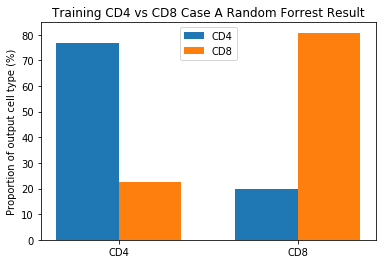

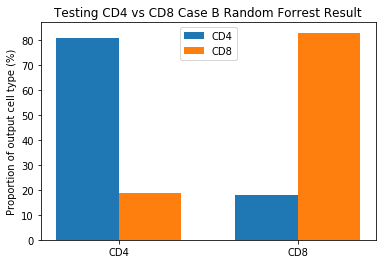

In [103]:
#Show the result
#Case A
loo = LeaveOneOut()
rfc = RandomForestClassifier(n_estimators=400, random_state=random_state)
y_pred = cross_val_predict(rfc, X_train_A, y_train_A, cv=loo)
cm_train = confusion_matrix(y_train_A,  y_pred)
print('Case A, Confusion Matrix Train :')
print(cm_train)
rfc.fit(X_train_A,y_train_A)
cm_test = confusion_matrix(y_test_A,  rfc.predict(X_test_A))
print('Case A, Confusion Matrix Test :')
print(cm_test)
#print('Train acc. %f' %(np.mean(cross_val_score(rfc, X_train_A, y_train_A, cv=loo))*100))
print('Test acc. %f' %(rfc.score(X_test_A,y_test_A)*100))


N = 2
ind = np.arange(N)
width = 0.35
CD4_out = cm_train[:,0]/np.sum(cm_train[0,:])*100
CD8_out = cm_train[:,1]/np.sum(cm_train[1,:])*100
plt.bar(ind,CD4_out, width, label='CD4')
plt.bar(ind+width,CD8_out, width, label='CD8')
plt.ylabel('Proportion of output cell type (%)')
plt.title('Training CD4 vs CD8 Case A Random Forrest Result')
plt.xticks(ind + width / 2, ('CD4', 'CD8'))
plt.legend(loc='best')
plt.show()

N = 2
ind = np.arange(N)
width = 0.35
CD4_out = cm_test[:,0]/np.sum(cm_test[0,:])*100
CD8_out = cm_test[:,1]/np.sum(cm_test[1,:])*100
plt.bar(ind,CD4_out, width, label='CD4')
plt.bar(ind+width,CD8_out, width, label='CD8')
plt.ylabel('Proportion of output cell type (%)')
plt.title('Testing CD4 vs CD8 Case B Random Forrest Result')
plt.xticks(ind + width / 2, ('CD4', 'CD8'))
plt.legend(loc='best')
plt.show()

Case B, Confusion Matrix Train :
[[215  22]
 [ 17 230]]
Case B, Confusion Matrix Test :
[[56  3]
 [ 5 57]]
Test acc. 93.388430


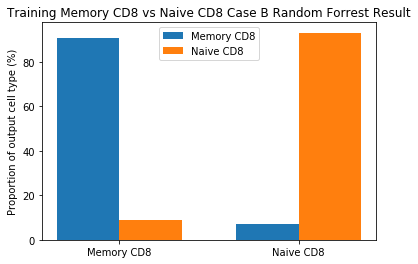

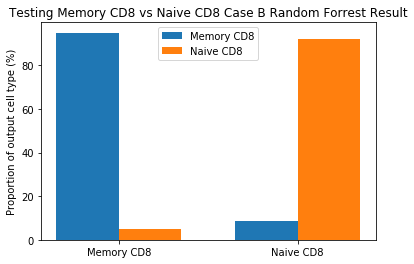

In [105]:
#Dont forget to choose selected feature
loo = LeaveOneOut()
rfc = RandomForestClassifier(n_estimators=600, random_state=random_state)
y_pred = cross_val_predict(rfc, X_train_B, y_train_B, cv=loo)
cm_train = confusion_matrix(y_train_B,  y_pred)
print('Case B, Confusion Matrix Train :')
print(cm_train)
rfc.fit(X_train_B,y_train_B)
cm_test = confusion_matrix(y_test_B,  rfc.predict(X_test_B))
print('Case B, Confusion Matrix Test :')
print(cm_test)
#print('Train acc. %f' %(np.mean(cross_val_score(rfc, X_train_B, y_train_B, cv=loo))*100))
print('Test acc. %f' %(rfc.score(X_test_B,y_test_B)*100))

N = 2
ind = np.arange(N)
width = 0.35
MCD8_out = cm_train[:,0]/np.sum(cm_train[0,:])*100
NCD8_out = cm_train[:,1]/np.sum(cm_train[1,:])*100
plt.bar(ind,MCD8_out, width, label='Memory CD8')
plt.bar(ind+width,NCD8_out, width, label='Naive CD8')
plt.ylabel('Proportion of output cell type (%)')
plt.title('Training Memory CD8 vs Naive CD8 Case B Random Forrest Result')
plt.xticks(ind + width / 2, ('Memory CD8', 'Naive CD8'))
plt.legend(loc='best')
plt.show()

N = 2
ind = np.arange(N)
width = 0.35
MCD8_out = cm_test[:,0]/np.sum(cm_test[0,:])*100
NCD8_out = cm_test[:,1]/np.sum(cm_test[1,:])*100
plt.bar(ind,MCD8_out, width, label='Memory CD8')
plt.bar(ind+width,NCD8_out, width, label='Naive CD8')
plt.ylabel('Proportion of output cell type (%)')
plt.title('Testing Memory CD8 vs Naive CD8 Case B Random Forrest Result')
plt.xticks(ind + width / 2, ('Memory CD8', 'Naive CD8'))
plt.legend(loc='best')
plt.show()

Case B, Confusion Matrix Train :
[[215  22]
 [ 17 230]]
Case B, Confusion Matrix Test :
[[56  3]
 [ 5 57]]
Test acc. 93.388430


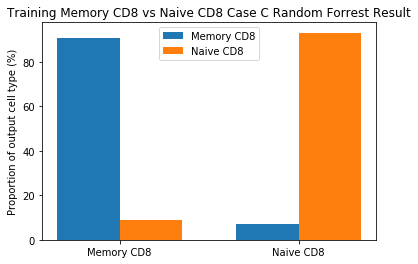

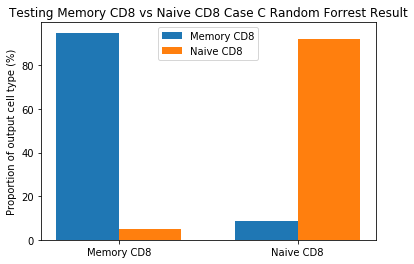

In [106]:
#Dont forget to choose selected feature
#B Case
loo = LeaveOneOut()
rfc = RandomForestClassifier(n_estimators=600, random_state=random_state)
y_pred = cross_val_predict(rfc, X_train_B, y_train_B, cv=loo)
cm_train = confusion_matrix(y_train_B,  y_pred)
print('Case B, Confusion Matrix Train :')
print(cm_train)
rfc.fit(X_train_B,y_train_B)
cm_test = confusion_matrix(y_test_B,  rfc.predict(X_test_B))
print('Case B, Confusion Matrix Test :')
print(cm_test)
#print('Train acc. %f' %(np.mean(cross_val_score(rfc, X_train_B, y_train_B, cv=loo))*100))
print('Test acc. %f' %(rfc.score(X_test_B,y_test_B)*100))

N = 2
ind = np.arange(N)
width = 0.35
MCD8_out = cm_train[:,0]/np.sum(cm_train[0,:])*100
NCD8_out = cm_train[:,1]/np.sum(cm_train[1,:])*100
plt.bar(ind,MCD8_out, width, label='Memory CD8')
plt.bar(ind+width,NCD8_out, width, label='Naive CD8')
plt.ylabel('Proportion of output cell type (%)')
plt.title('Training Memory CD8 vs Naive CD8 Case C Random Forrest Result')
plt.xticks(ind + width / 2, ('Memory CD8', 'Naive CD8'))
plt.legend(loc='best')
plt.show()

N = 2
ind = np.arange(N)
width = 0.35
MCD8_out = cm_test[:,0]/np.sum(cm_test[0,:])*100
NCD8_out = cm_test[:,1]/np.sum(cm_test[1,:])*100
plt.bar(ind,MCD8_out, width, label='Memory CD8')
plt.bar(ind+width,NCD8_out, width, label='Naive CD8')
plt.ylabel('Proportion of output cell type (%)')
plt.title('Testing Memory CD8 vs Naive CD8 Case C Random Forrest Result')
plt.xticks(ind + width / 2, ('Memory CD8', 'Naive CD8'))
plt.legend(loc='best')
plt.show()

Case A, Confusion Matrix Train :
[[ 80 165]
 [ 16 239]]
Case A, Confusion Matrix Test :
[[18 44]
 [ 5 59]]
Train acc. 63.800000
Test acc. 61.111111


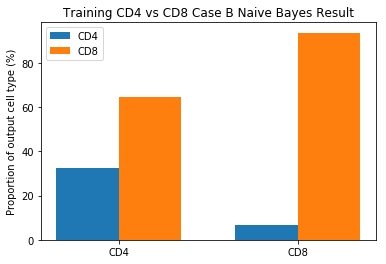

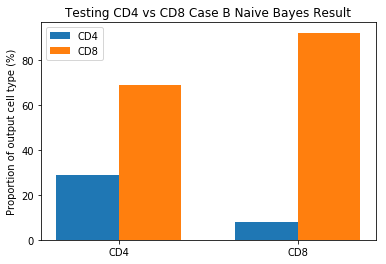

In [23]:
#Show the result
#Dont forget to choose selected feature
#A Case
gnb = GaussianNB()
loo = LeaveOneOut()
y_pred = cross_val_predict(gnb, X_train_A, y_train_A, cv=loo)
cm_train = confusion_matrix(y_train_A,  y_pred)
print('Case A, Confusion Matrix Train :')
print(cm_train)
gnb.fit(X_train_A,y_train_A)
cm_test = confusion_matrix(y_test_A,  gnb.predict(X_test_A))
print('Case A, Confusion Matrix Test :')
print(cm_test)
print('Train acc. %f' %(np.mean(cross_val_score(gnb, X_train_A, y_train_A, cv=loo))*100))
print('Test acc. %f' %(gnb.score(X_test_A,y_test_A)*100))


N = 2
ind = np.arange(N)
width = 0.35
CD4_out = cm_train[:,0]/np.sum(cm_train[0,:])*100
CD8_out = cm_train[:,1]/np.sum(cm_train[1,:])*100
plt.bar(ind,CD4_out, width, label='CD4')
plt.bar(ind+width,CD8_out, width, label='CD8')
plt.ylabel('Proportion of output cell type (%)')
plt.title('Training CD4 vs CD8 Case B Naive Bayes Result')
plt.xticks(ind + width / 2, ('CD4', 'CD8'))
plt.legend(loc='best')
plt.show()

N = 2
ind = np.arange(N)
width = 0.35
CD4_out = cm_test[:,0]/np.sum(cm_test[0,:])*100
CD8_out = cm_test[:,1]/np.sum(cm_test[1,:])*100
plt.bar(ind,CD4_out, width, label='CD4')
plt.bar(ind+width,CD8_out, width, label='CD8')
plt.ylabel('Proportion of output cell type (%)')
plt.title('Testing CD4 vs CD8 Case B Naive Bayes Result')
plt.xticks(ind + width / 2, ('CD4', 'CD8'))
plt.legend(loc='best')
plt.show()

Case B, Confusion Matrix Train :
[[129 108]
 [ 27 220]]
Case B, Confusion Matrix Test :
[[39 20]
 [ 6 56]]
Train acc. 72.107438
Test acc. 78.512397


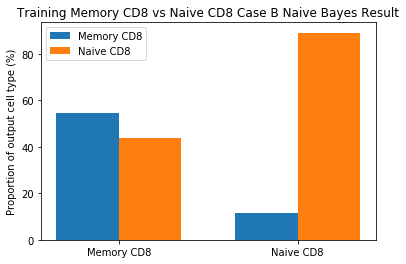

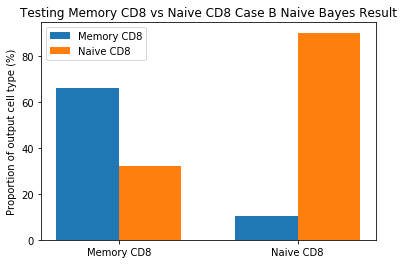

In [22]:
#B Case
gnb = GaussianNB()
loo = LeaveOneOut()
y_pred = cross_val_predict(gnb, X_train_B, y_train_B, cv=loo)
cm_train = confusion_matrix(y_train_B,  y_pred)
print('Case B, Confusion Matrix Train :')
print(cm_train)
gnb.fit(X_train_B,y_train_B)
cm_test = confusion_matrix(y_test_B,  gnb.predict(X_test_B))
print('Case B, Confusion Matrix Test :')
print(cm_test)
print('Train acc. %f' %(np.mean(cross_val_score(gnb, X_train_B, y_train_B, cv=loo))*100))
print('Test acc. %f' %(gnb.score(X_test_B,y_test_B)*100))

N = 2
ind = np.arange(N)
width = 0.35
MCD8_out = cm_train[:,0]/np.sum(cm_train[0,:])*100
NCD8_out = cm_train[:,1]/np.sum(cm_train[1,:])*100
plt.bar(ind,MCD8_out, width, label='Memory CD8')
plt.bar(ind+width,NCD8_out, width, label='Naive CD8')
plt.ylabel('Proportion of output cell type (%)')
plt.title('Training Memory CD8 vs Naive CD8 Case B Naive Bayes Result')
plt.xticks(ind + width / 2, ('Memory CD8', 'Naive CD8'))
plt.legend(loc='best')
plt.show()

N = 2
ind = np.arange(N)
width = 0.35
MCD8_out = cm_test[:,0]/np.sum(cm_test[0,:])*100
NCD8_out = cm_test[:,1]/np.sum(cm_test[1,:])*100
plt.bar(ind,MCD8_out, width, label='Memory CD8')
plt.bar(ind+width,NCD8_out, width, label='Naive CD8')
plt.ylabel('Proportion of output cell type (%)')
plt.title('Testing Memory CD8 vs Naive CD8 Case B Naive Bayes Result')
plt.xticks(ind + width / 2, ('Memory CD8', 'Naive CD8'))
plt.legend(loc='best')
plt.show()

Case C, Confusion Matrix Train :
[[151  26  68]
 [ 31 103 103]
 [ 24  17 206]]
Case C, Confusion Matrix Test :
[[33 11 18]
 [10 24 25]
 [ 4  1 57]]
Train acc. 63.100137
Test acc. 62.295082


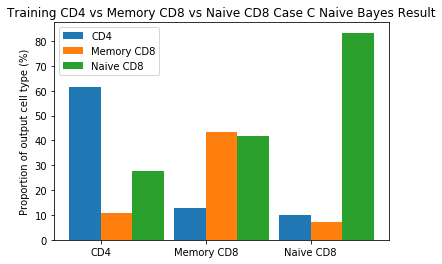

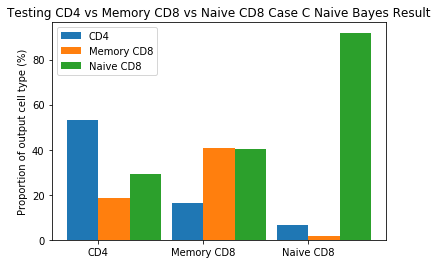

In [24]:
#C Case
gnb = GaussianNB()
loo = LeaveOneOut()
y_pred = cross_val_predict(gnb, X_train_C, y_train_C, cv=loo)
cm_train = confusion_matrix(y_train_C,  y_pred)
print('Case C, Confusion Matrix Train :')
print(cm_train)
gnb.fit(X_train_C,y_train_C)
cm_test = confusion_matrix(y_test_C,  gnb.predict(X_test_C))
print('Case C, Confusion Matrix Test :')
print(cm_test)
print('Train acc. %f' %(np.mean(cross_val_score(gnb, X_train_C, y_train_C, cv=loo))*100))
print('Test acc. %f' %(gnb.score(X_test_C,y_test_C)*100))


N = 3
ind = np.arange(N)
width = 0.3
CD4_out = cm_train[:,0]/np.sum(cm_train[0,:])*100
MCD8_out = cm_train[:,1]/np.sum(cm_train[1,:])*100
NCD8_out = cm_train[:,2]/np.sum(cm_train[2,:])*100
plt.bar(ind,CD4_out, width, label='CD4')
plt.bar(ind+width,MCD8_out, width, label='Memory CD8')
plt.bar(ind+2*width,NCD8_out, width, label='Naive CD8')
plt.ylabel('Proportion of output cell type (%)')
plt.title('Training CD4 vs Memory CD8 vs Naive CD8 Case C Naive Bayes Result')
plt.xticks(ind + width / 2, ('CD4', 'Memory CD8', 'Naive CD8'))
plt.legend(loc='best')
plt.show()

N = 3
ind = np.arange(N)
width = 0.3
CD4_out = cm_test[:,0]/np.sum(cm_test[0,:])*100
MCD8_out = cm_test[:,1]/np.sum(cm_test[1,:])*100
NCD8_out = cm_test[:,2]/np.sum(cm_test[2,:])*100
plt.bar(ind,CD4_out, width, label='CD4')
plt.bar(ind+width,MCD8_out, width, label='Memory CD8')
plt.bar(ind+2*width,NCD8_out, width, label='Naive CD8')
plt.ylabel('Proportion of output cell type (%)')
plt.title('Testing CD4 vs Memory CD8 vs Naive CD8 Case C Naive Bayes Result')
plt.xticks(ind + width / 2, ('CD4', 'Memory CD8', 'Naive CD8'))
plt.legend(loc='best')
plt.show()

<Figure size 1152x864 with 0 Axes>

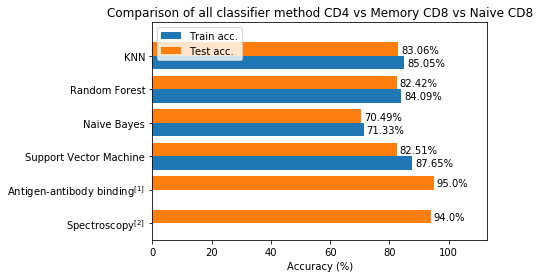

In [25]:
#Show comparison result
Train_acc = [0, 0, 87.65, 71.33, 84.09, 85.05]
Test_acc = [94, 95, 82.51, 70.49, 82.42, 83.06]



index = ['Spectroscopy$^{[2]}$', 'Antigen-antibody binding$^{[1]}$', 'Support Vector Machine', 'Naive Bayes', 'Random Forest', 'KNN']

df = pd.DataFrame({'Train acc.': Train_acc, 'Test acc.': Test_acc}, index = index)

plt.figure(figsize=(16, 12))
ax = df.plot.barh(width=0.8)
plt.axis([0, 113, -.5, 6])
ax.set_xlabel('Accuracy (%)')
ax.set_title('Comparison of all classifier method CD4 vs Memory CD8 vs Naive CD8')
plt.legend(loc = 'upper left')

# set individual bar lables using above list
idx = 0
for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    idx += 1
    if i.get_width()!=0:
        ax.text(i.get_width()+1, i.get_y()+.09, \
            str(round((i.get_width()), 2))+'%')
plt.show()